In [1]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

# args = argsCommand(true)
# datasetName = args[1]
# #datasetName value: organ_tissue_authorYear without space
# dataFormat = args[2]
# #dataFormat value: tsv (tab separated), 10X (sparse)

datasetName = 'Blood_Blood_HCLAdult-Peripheral-Blood2'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/data1/ljq/jupyter_code/bhyhcad/bhyhcad/hcl_all/Blood_Blood_HCLAdult-Peripheral-Blood2")
library(Seurat)
library(data.table)
library(ggplot2)
#library(flexclust)
#install.packages('flexclust')

# setwd("/path/to/dataset/")
# library(Seurat)
# library(data.table)
# library(ggplot2)
# library(flexclust)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation_hcad.tsv"), h = T, sep = "\t", row.names = 1)
}
# Extract demo data for test
#data.matrix <- data.matrix[,1:500]
#data.metadata <- data.metadata[1:500,]
#data.annotation <- data.annotation[1:500,,drop=FALSE]

# Pre-processing
min.cells = 3
min.features = 0
nFeature_RNA_range = c(20, 2500)
percent.mt.thre = 15

# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

# 2. run sctransform 
#dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Centering and scaling data matrix

PC_ 1 
Positive:  FTH1, FTL, CD74, CTSS, SAT1, IFITM3, S100A4, AIF1, HLA-DRA, FCER1G 
	   LST1, S100A11, TMSB10, S100A6, CST3, B2M, FCGR3A, FCN1, CD52, MS4A7 
	   LGALS2, APOBEC3A, HLA-DQA1, RPS27, MS4A6A, TMSB4X, WARS, CTSL, ISG15, RHOC 
Negative:  CD24, S100P, RNASE3, BPI, MS4A3, CEACAM6, CEACAM8, DEFA3, DEFA4, SLPI 
	   ANXA3, ELANE, CTSG, LCN2, AZU1, MPO, EMB, RNASE2, PGLYRP1, LTF 
	   COL17A1, RGCC, ARG1, TCN1, CD59, CHI3L1, DPY19L1P1, RGL4, STOM, NUCB2 
PC_ 2 
Positive:  GZMA, JCHAIN, CCL5, TRBC2, IL32, STMN1, CD3D, MZB1, FABP5, KIAA0101 
	   PTTG1, TNFRSF17, SUB1, NKG7, IGKC, TRAC, SEC11C, SH2D1A, GZMH, DERL3 
	   CCDC167, C12orf75, FKBP11, PPIB, ITM2C, IGHA1, HMGB1, MT1E, CCL4, RPA3 
Negative:  LYZ, CTSS, FCN1, S100A9, FTL, S100A8, LST1, S100A11, FCER1G, SAT1 
	   S100A6, HLA-DRA, AIF1, IFITM3, S100A4, FTH1, S100P, CD24, SRGN, CST3 
	   CEACAM8, BPI, MS

png 
  2

In [6]:
data.annotation

,cell_cluster
,<fct>
AdultPeripheralBlood_2.AAAACGAAAACGAAGTAC,Monocyte
AdultPeripheralBlood_2.AAAACGAAAACGCTCGCA,Neutrophil_DEFA3 high
AdultPeripheralBlood_2.AAAACGACACCCGAATTA,T cell_IL7R high
AdultPeripheralBlood_2.AAAACGACACCCTGCAAT,Monocyte
AdultPeripheralBlood_2.AAAACGACCTGACCGCTA,Macrophage
AdultPeripheralBlood_2.AAAACGACCTGATCACTT,B cell_IGLC2 high
AdultPeripheralBlood_2.AAAACGAGGACTTATTGT,B cell_IGHG2 high
AdultPeripheralBlood_2.AAAACGAGGACTTGTGCG,Macrophage
AdultPeripheralBlood_2.AAAACGATACAGCCAGAC,Monocyte


In [2]:
pcDim = 30 # set as 75 in this case 
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.9, n.start = 10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5296
Number of edges: 266716

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7607
Number of communities: 10
Elapsed time: 0 seconds


In [3]:
# Visulize the clustering result
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
21:01:54 UMAP embedding parameters a = 0.9922 b = 1.112

21:01:54 Read 5296 rows and found 30 numeric columns

21:01:54 Using Annoy for neighbor search, n_neighbors = 30

21:01:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:01:55 Writing NN index file to temp file /tmp/RtmpnIgh2d/file31d126c8ac38

21:01:55 Searching Annoy index using 1 thread, search_k = 3000

21:01:56 Annoy recall = 100%

21:01:56 Commencing smooth kNN distance calibration using 1 thread

21:01:57 Initializing fr

In [4]:
new.cluster.ids<-c('Blood-Connective Tissue-Macrophage-FCER1G FCGR3A','Blood-Connective Tissue-Monocyte-CD14 FCN1','Blood-Connective Tissue-unknown','Blood-Connective Tissue-Hemopoietic stem cell-CD99','Blood-Connective Tissue-T cell-CD3D','Blood-Connective Tissue-Neutrophil-CD24','Blood-Connective Tissue-Plasma B Cell-JCHAIN','Blood-Connective Tissue-T cell-CD3D','Blood-Connective Tissue-Erythrocyte-AHSP','Blood-Connective Tissue-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-GATA2')

In [5]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
hcad.label = Idents(dataobj)
dataobj <- AddMetaData(dataobj, metadata = hcad.label,col.name = 'hcad.label')

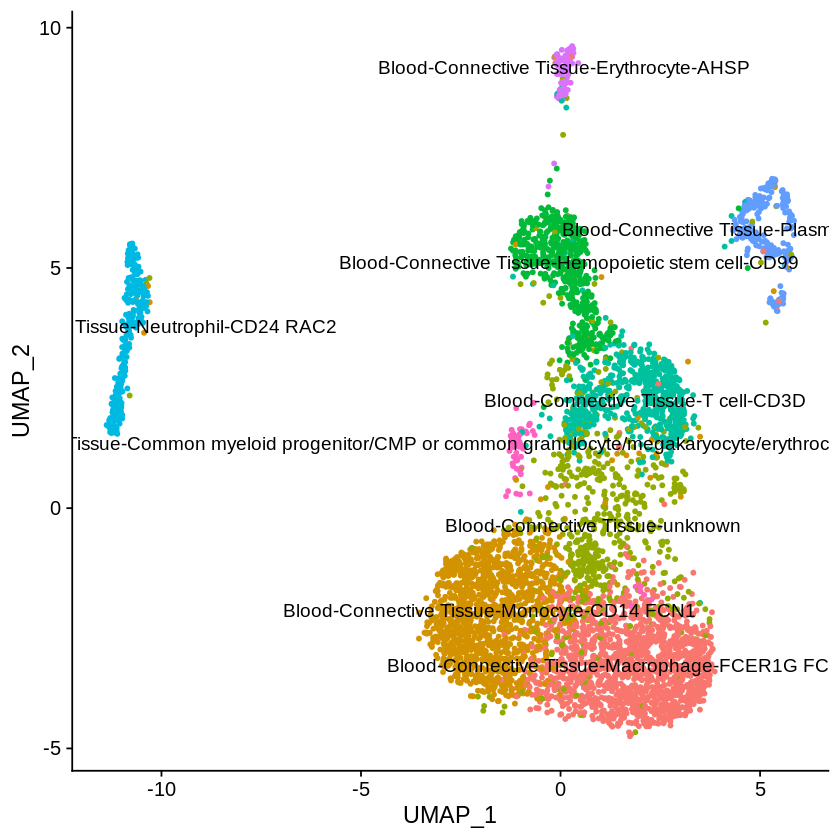

In [11]:
DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()

In [7]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap, width = 8, height = 5)

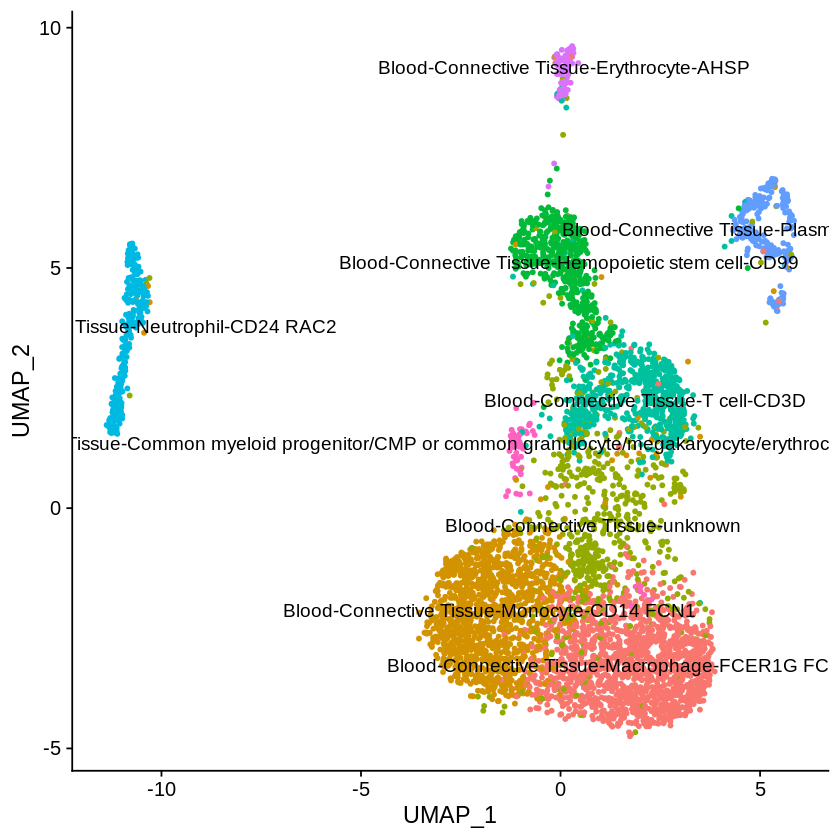

In [13]:
p_umap

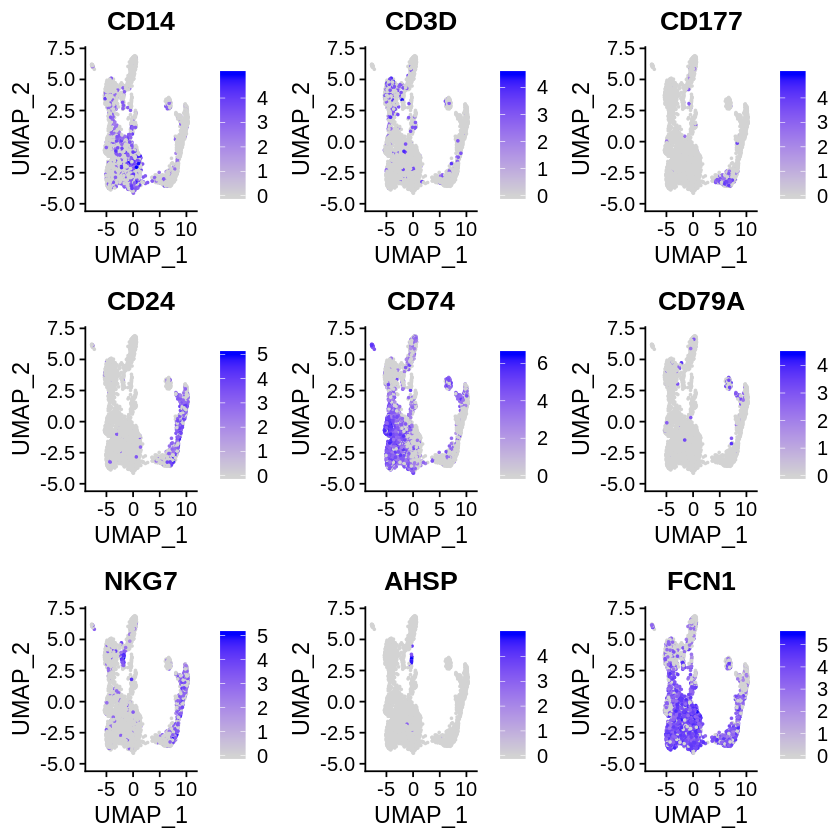

In [20]:
FeaturePlot(dataobj,features = c('CD14','CD3D','CD177','CD24','CD74','CD79A','NKG7','AHSP','FCN1'))

In [25]:
dataobj

An object of class Seurat 
13539 features across 4432 samples within 1 assay 
Active assay: RNA (13539 features)
 2 dimensional reductions calculated: pca, umap

In [14]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cluster.ids", pt.size=1)

ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'cluster.ids' in this Seurat object


In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)

ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'cell_cluster' in this Seurat object


In [8]:
dataobj[['RNA']]@counts[1:5,1:5]

ERROR: Error in eval(expr, envir, enclos): object 'dataobj' not found


In [ ]:
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

In [ ]:
ElbowPlot(dataobj)

In [15]:
# Compare the seurat clusters with original clusters
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

ERROR: Error in randIndex(dataobj$cell_cluster, dataobj$seurat_clusters): could not find function "randIndex"


In [8]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    p_umap3 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_ontology_class", pt.size=1)+NoLegend()
    ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap3, width = 8, height = 5)
}

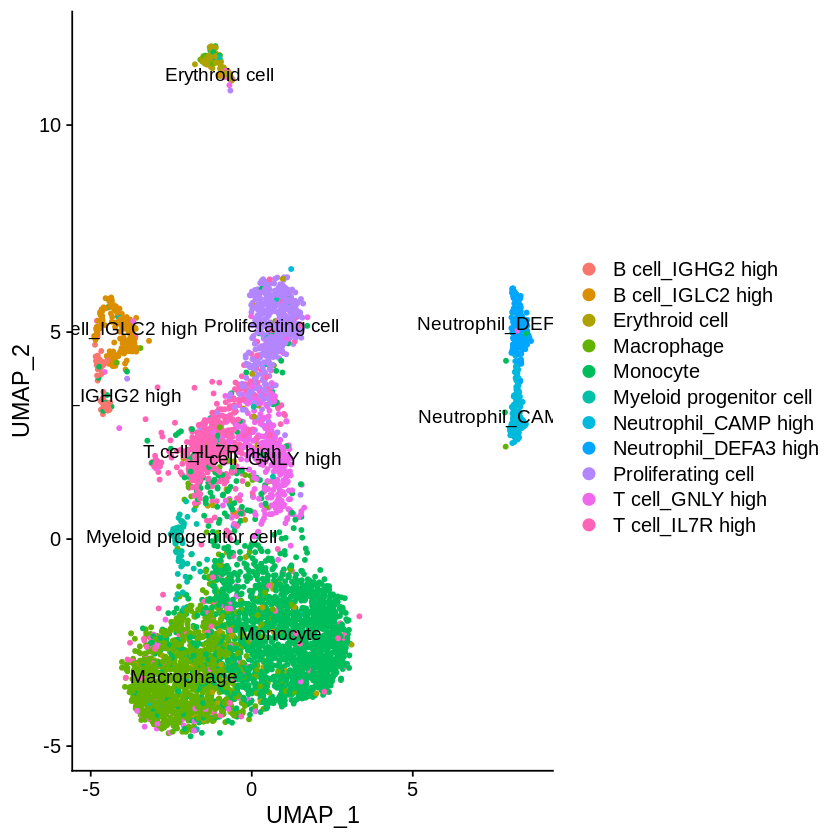

In [7]:
p_umap2

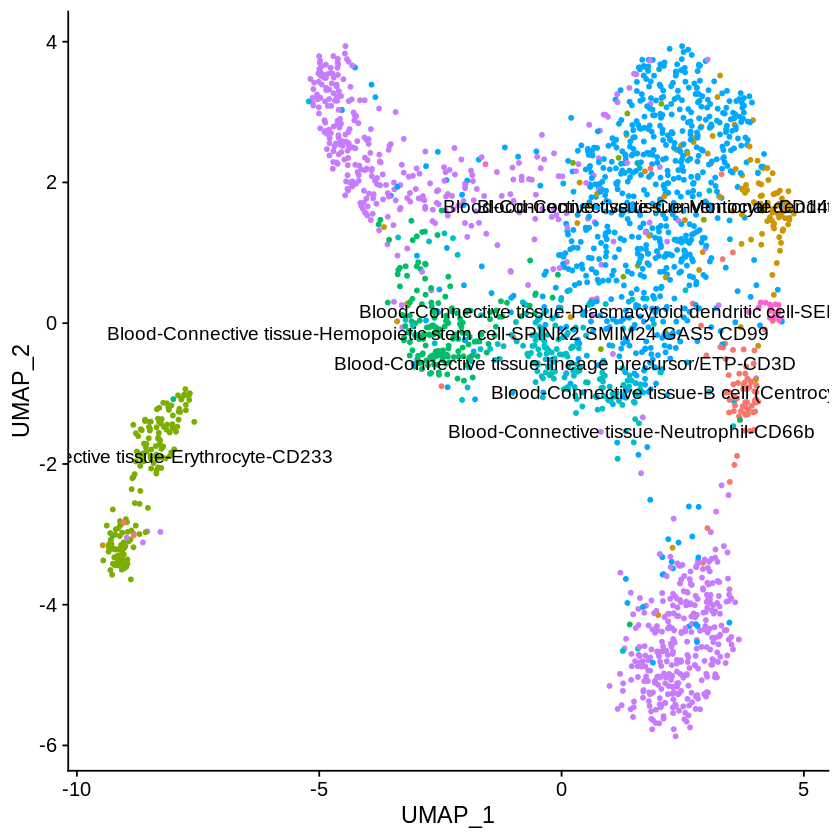

In [7]:
p_umap3

In [46]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster Blood-Connective Tissue-Monocyte-CD14
Calculating cluster Blood-Connective Tissue-T cell-CD3D
Calculating cluster Blood-Connective Tissue-Neutrophil-CD177
Calculating cluster Blood-Connective Tissue-Hemopoietic stem cell-CD99
Calculating cluster Blood-Connective Tissue-Neutrophil-CD24
Calculating cluster Blood-Connective Tissue-Monocyte-FCN1
Calculating cluster Blood-Connective Tissue-Plasma B Cell-CD79A
Calculating cluster Blood-Connective Tissue-Conventional dendritic cell-CD74
Calculating cluster Blood-Connective Tissue-Megakaryocyte-GP9
Calculating cluster Blood-Connective Tissue-NK cell-NKG7
Calculating cluster Blood-Connective Tissue-Plasma B Cell-JCHAIN
Calculating cluster Blood-Connective Tissue-Erythrocyte-AHSP


In [45]:
write.table(Idents(dataobj), file = paste0(datasetName,".seurat.annotation_hcad.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

In [15]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

In [9]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))